# Fitting AUSF

The model requires the fitting of pig population dynamics and ASF disease dynamics. We first fit the population to ensure that the population returns to the carrying capacity

### Load Modules

In [1105]:
using GpABC, Distances, Distributions, Plots, StatsBase, Printf
using DiffEqCallbacks, DifferentialEquations, LinearAlgebra
using DelimitedFiles, DataFrames, LinearAlgebra, SparseArrays


In [2]:
using QuadGK

In [3]:
using Random

In [1107]:
include("/home/callum/ASF/Modules/ASF_input.jl");
include("/home/callum/ASF/Modules/ASF_model.jl");
#include("/home/callum/ASF/Modules/ASF_analysis.jl")

In [5]:
input_path = "/home/callum/ASF/Inputs/"; #path to model data

### Model

In [1567]:

input = ASF_Inputs.Model_Data(input_path, true); #loading the model input

In [1706]:
const nt = input.Parameters.Populations.cum_sum[end] #total number of groups and farms
const nc = 5 #number of classes
const eqs = 11 #number of processes

const dc = sparse(zeros(nt*nc,nt*eqs))

#const _dc = zeros(nt*5,nt*10)

dc[0*nc*nt+1:nc*nt*eqs+nc:end] .= 1
dc[1*nc*nt+1:nc*nt*eqs+nc:end] .= -1
dc[2*nc*nt+1:nc*nt*eqs+nc:end] .= -1
dc[10*nc*nt+1:nc*nt*eqs+nc:end] .= 1

dc[2*nc*nt+2:nc*nt*eqs+nc:end] .= 1
dc[3*nc*nt+2:nc*nt*eqs+nc:end] .= -1
dc[4*nc*nt+2:nc*nt*eqs+nc:end] .= -1

dc[4*nc*nt+3:nc*nt*eqs+nc:end] .= 1
dc[5*nc*nt+3:nc*nt*eqs+nc:end] .= -1
dc[6*nc*nt+3:nc*nt*eqs+nc:end] .= -1
dc[7*nc*nt+3:nc*nt*eqs+nc:end] .= -1

dc[7*nc*nt+4:nc*nt*eqs+nc:end] .= 1
dc[8*nc*nt+4:nc*nt*eqs+nc:end] .= -1
dc[10*nc*nt+4:nc*nt*eqs+nc:end] .= -1


dc[5*nc*nt+5:nc*nt*eqs+nc:end] .= 1
dc[6*nc*nt+5:nc*nt*eqs+nc:end] .= 1
dc[9*nc*nt+5:nc*nt*eqs+nc:end] .= -1;

In [1707]:
function regular_c(du,u,p,t,counts,mark)  
    mul!(du,dc,counts)
    nothing
end

regular_c (generic function with 1 method)

In [1708]:

function run_analysis(sol)
   
        data = reduce(vcat,transpose.(sol.u))
        data[data .< 0 ] .= 0
   
        s_d = data[:,1:5:end]
        e_d = data[:,2:5:end]
        i_d = data[:,3:5:end]
        r_d = data[:,4:5:end]
        c_d = data[:,5:5:end]
 
        disease_total = e_d + i_d + c_d #classes with disease,
        disease_alive = e_d + i_d
 
        disease_free = s_d + r_d #classes without disease,
 
        disease_sum = sum(disease_total,dims=2)
        disease_alive_sum =  sum(disease_alive,dims=2)
        disease_free_sum = sum(disease_free,dims=2)
        population_sum = disease_alive_sum + disease_free_sum;
   
        return disease_sum, disease_alive_sum, disease_free_sum, population_sum
    end

run_analysis (generic function with 1 method)

In [1353]:
input = ASF_Inputs.Model_Data(input_path, true); #loading the model input
params = ASF_Model.convert(input.Parameters);

In [1349]:
function birth_pulse_vector(t,k,s,p)
    return k*exp(-s*cos(pi*(t+p)/365)^2)
end
function birth_pulse(t,k,s,p)
    return k.*exp.(-s.*cos.(pi.*(t.+p)./365).^2)
end

birth_pulse (generic function with 1 method)

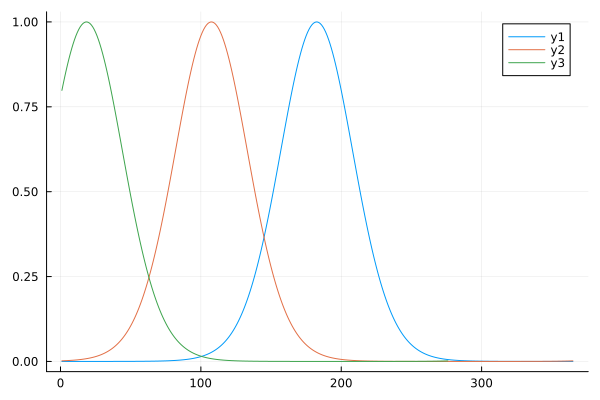

In [1051]:
plot(birth_pulse(1:365,1,10,0))
plot!(birth_pulse(1:365,1,10,params[18]))
plot!(birth_pulse(90:365,1,10,params[18]))



In [1766]:
function asf_model_pop(out,u,p,t)
    #ASF model for a single population (can make some speed increases) without farms!

    β_i, β_o, β_b, μ_p, K, ζ, γ, ω, ρ, λ, κ, σ, θ, η, g, Seasonal, bw, bo, k, la, lo, Area  = p 
    
    
    year = 365 #days in a year

    u[u.<0] .= 0
    
    S = Vector{UInt32}(u[1:5:end])
    
    p_mag = birth_pulse_vector(t,k,bw,0)
    Births = p_mag.*(σ .* S .+ ((1-σ)) .* sqrt.(S .* K))#S.^(1-θ) .* K.^θ)
    
    #now stopping boar births
    mask_boar = (K .== 1) .& (S .> 0) #boars with a positive population
    boar_births = p_mag*sum(mask_boar)
    Births[mask_boar] .= 0
    mask_p_s = (S .> 1) .& (K .> 1) #moving it to postive 
    Births[mask_p_s] .+= boar_births ./ sum(mask_p_s) 
     
    
    n_empty  = sum(S .== 0 ) 
    n_r = (n_empty/500)^2
    
    
    if (n_empty/500) > 0.01
        
    dd = copy(S)
    dd[dd .< 2] .= 0
    connected_pops = β_b * dd
    
        #Groups with 3 or more pigs can have emigration
    mask_em =  (dd .> 0) #populations that will have emigration

    em_force = sum(Births[mask_em]) #"extra" births in these populations that we will transfer
        
    mask_im = (S .== 0) .& (connected_pops .> 1) #population zero but connected groups have 5 or more pigs
        
    Births[mask_em] .*= n_r
    Births[mask_im] .= (1 - n_r)*em_force/sum(mask_im)
        end 
    out[1:11:end] .= Births
    out[2:11:end] .= S.*μ_p.*(σ .+ (1-σ).*sqrt.(S./K))*g
   
    nothing
end

asf_model_pop (generic function with 1 method)

In [1767]:
input = ASF_Inputs.Model_Data(input_path,0.15);

U0 = copy(input.U0);
U0[1:5:end] += (U0[2:5:end] +U0[3:5:end]) #setting init pop to zero
U0[2:5:end] .= 0
U0[3:5:end] .= 0;

#U0[U0 .> 3] .= 2;
params = ASF_Model.convert(input.Parameters)

#params[15] = 1 #corpse decay rates

Time = (0.0,10*365)

(0.0, 3650)

In [1768]:
rj = RegularJump(asf_model_pop, regular_c, eqs*nt)

    prob = DiscreteProblem(U0,Time,params)

    jump_prob = JumpProblem(prob,Direct(),rj)

   

    outputs = solve(jump_prob, SimpleTauLeaping(),dt=1);


In [1769]:
sqrt(1.6e-5)*500

2.0

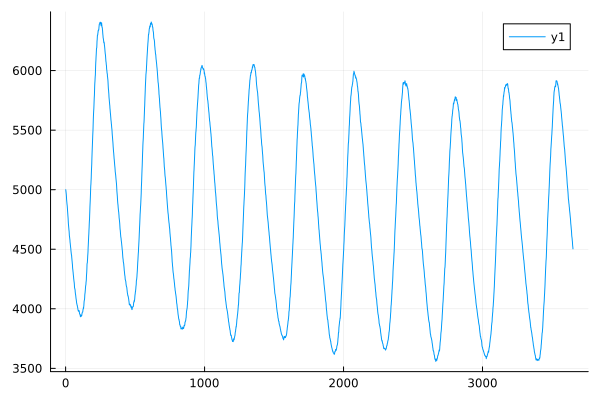

In [1770]:
a,b,c,d = run_analysis(outputs)
plot(d)

In [1771]:
500*.2+0.8*6*500

2500.0000000000005

In [1772]:
hh = Normal(180,36.48)

Normal{Float64}(μ=180.0, σ=36.48)

In [1773]:
 quantile.(hh, [0.05, 0.95])

2-element Vector{Float64}:
 119.99573968881029
 240.00426031118968

### Fitting Population

In [1774]:
dummy = simulator_function_pop([0.95])

LoadError: DimensionMismatch: arrays could not be broadcast to a common size; got a dimension with lengths 2191 and 3651

In [1775]:
dist = euclidean(obs[:],dummy)

LoadError: DimensionMismatch: first array has length 3 which does not match the length of the second, 3651.

In [1776]:
threshold

1.5105876340020805

In [1810]:
AUSF_pop = function(params,Tspan, U0)
    #function that runs model for fitting

    rj = RegularJump(asf_model_pop, regular_c, eqs*nt)

    prob = DiscreteProblem(U0,Tspan,params)

    jump_prob = JumpProblem(prob,Direct(),rj)

    ensemble_prob_m = EnsembleProblem(jump_prob)

    outputs = solve(ensemble_prob_m, SimpleTauLeaping(), trajectories= n_runs,EnsembleThreads(),dt=1);

    res = eval_out_pop(outputs,U0)

    return res
end
    

function simulator_function_pop(var_params)

   
    input = ASF_Inputs.Model_Data(input_path,0.15);

    U0 = copy(input.U0);
    U0[1:5:end] += (U0[2:5:end] +U0[3:5:end]) #setting init pop to zero
    U0[2:5:end] .= 0
    U0[3:5:end] .= 0;
    
    params = ASF_Model.convert(input.Parameters)
    
    params[15] = var_params[1] #corpse decay rates
    
    Time = (0.0,n_years*365)
    #now we run simulation!
    AUSF_pop(params, Time, U0)
end

function eval_out_pop(output, U0)
    output_final = Matrix{Float64}(undef,(n_years*365+1,1))
    dist = zeros(Float64,n_runs)
    K = sum(U0)
   dummy = zeros(n_years*365+1)
    
    for i = 1:n_runs
        sol = output[i]
        data = reduce(vcat,transpose.(sol.u))
        data[data .< 0 ] .= 0

        s_d = data[:,1:5:end]
        
        pop_sum = sum(s_d,dims=2)[:,1]
        
        pop_crop = pop_sum./ode_norm
 
        dummy += pop_crop/n_runs
        
    
    end
    output_final[:] = dummy
    dist = euclidean(obs[:],dummy)
    if dist < threshold
        println(1)
    
    end
    return output_final
    
end

function observed_params()
   
    obs =  Matrix{Float64}(undef,(n_years*365+1,1))
    
    obs .= 1
    
    return obs
end

observed_params (generic function with 1 method)

In [1811]:
#Need to figure out the norm
#Need to figure out the norm
input = ASF_Inputs.Model_Data(input_path, 0.15);

U0_ode = [sum(input.U0)];
p_ode = [input.Parameters.k[1], input.Parameters.bw[1],input.Parameters.σ[1],sum(input.Parameters.K),input.Parameters.μ_p[1]];
tspan_ode = (0.0,5*365.0);

In [1812]:
function density_carrying!(du,u,p,t)
    S = u[1]
    k, bw, σ, K, μ_p = p
   
    du[1] = birth_pulse_vector(t,k,bw,0).*(σ .* S .+ ((1-σ)) .* sqrt.(S.*K))-S.*μ_p.*(σ .+ ((1-σ)).*sqrt.(S./K))

end

density_carrying! (generic function with 1 method)

In [1813]:
prob_ode = ODEProblem(density_carrying!, [5000], (0.0,5*365.0), p_ode)
sol_ode = solve(prob_ode, saveat = 1,reltol=1e-8);
ode_norm = reduce(vcat,transpose.(sol_ode.u));

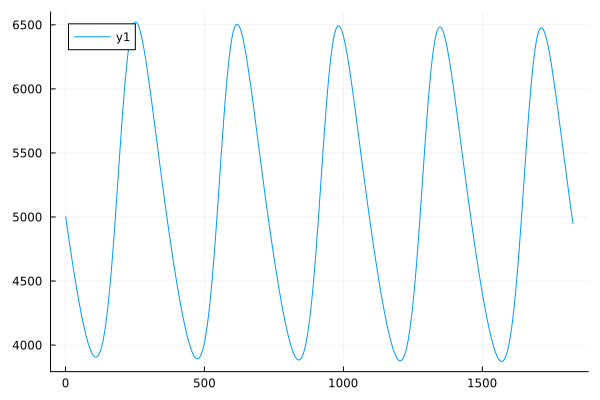

In [1814]:
plot(ode_norm)

In [1815]:
#Some key parameters for G

input_path = "/home/callum/ASF/Inputs/"; #path to model data
n_years = 5 #how many years each sim will run for
n_runs = 3 #how many runs for each param
obs = observed_params() #our observed (just array of ones, we normalise output to be relative to this)
priors = [Uniform(0.9, 1.0)];

In [1816]:
#Our params for fitting
n_particles = 100 #number of acceptances we want
devi = 0.975 #how close (from 0-1 with 1 being identical) do we want output to be to observed, used for threshold
threshold = sqrt((n_years*365+1)*((1-devi)^2));

In [1817]:
sim_result = SimulatedABCRejection(obs, simulator_function_pop, priors, threshold, n_particles; max_iter=10000, write_progress=false)#,

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


GpABC.SimulatedABCRejectionOutput(1, 100, 924, 1.0682930309610759, [0.9286509826568117; 0.9310066842126574; … ; 0.9300353018101984; 0.9190708574156579;;], [0.9283027520477858, 0.9349574295542927, 0.7537840669337227, 0.9644824693940939, 0.8822092633402306, 0.8265557904049552, 0.645500675877521, 0.743656065107897, 0.9132614783707086, 1.0015527648191962  …  0.9863849048082561, 0.9077981598818656, 0.7214347234963614, 1.0454416381758296, 1.0238362056187866, 0.8262567555176864, 0.6734877692437731, 0.7859078032169005, 0.7822889701448733, 0.9803857443972708], [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01  …  0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01])

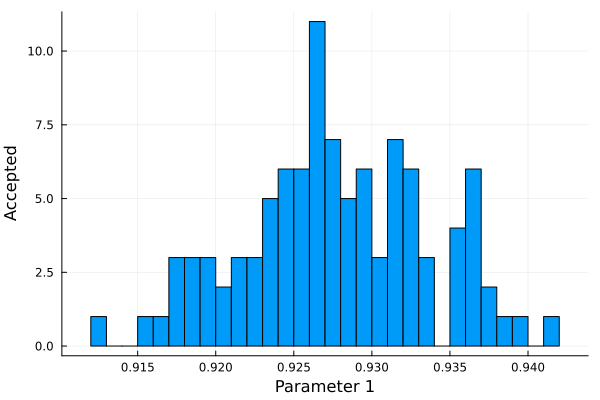

In [1818]:
plot(sim_result)

In [1819]:
median(sim_result.population)

0.927249593499315

In [1820]:
mean(sim_result.population)

0.9276895043560477

In [1185]:
sqrt(1000/4000)

0.5

In [1203]:
(50/1250)^2

0.0016

### Fitting ASF

Here we are fitting the diease dynamics to previously observed effects from outbreaks in the Baltic States

In [1821]:
function asf_model_one(out,u,p,t)
    #ASF model for a single population (can make some speed increases) without farms!

    β_i, β_o, β_b, μ_p, K, ζ, γ, ω, ρ, λ, κ, σ, θ, η, g, Seasonal, bw, bo, k, la, lo, Area    = p 
    ref_density = 1 #baseline density (from Baltics where modelled was fitted)
    year = 365 #days in a year

    u[u.<0] .= 0
    
    S = Vector{UInt8}(u[1:5:end])
    E = Vector{UInt8}(u[2:5:end])
    I = Vector{UInt8}(u[3:5:end])
    R = Vector{UInt8}(u[4:5:end])
    C = Vector{UInt8}(u[5:5:end])

    N = S .+ E .+ I .+ R .+ C
    Np = S .+ E .+ I .+ R
    
    N[N .== 0] .= 1
    
    tg = length(Np) #total groups in all populations
    tp = sum(Np) # total living pigs

    Density = sqrt((tp/Area)/ref_density) #density of population for beta
    Deaths = μ_p.*(σ .+ ((1-σ)).*sqrt.(Np)./sqrt.(K))*0.95
    

    Lambda = λ + la * cos((t + lo) * 2*pi/year)

    p_mag = birth_pulse_vector(t,k,bw,bo)
    Births = p_mag.*(σ .* Np .+ ((1-σ)) .* sqrt.(Np .* K))#Np.^(1-θ) .* K.^θ)
    
    #now stopping boar births
    mask_boar = (K .== 1) .& (Np .> 0) #boars with a positive population
    boar_births = p_mag*sum(mask_boar)
    Births[mask_boar] .= 0
    mask_p_s = (Np .> 1) .& (K .> 1) #moving it to postive 
    Births[mask_p_s] .+= boar_births ./ sum(mask_p_s) 
     
    
    n_empty  = sum(Np .== 0 ) 
    n_r = (n_empty/tg)^2
    
    
    if n_empty/tg > 0.01   
    dd = copy(Np)
    dd[dd .< 2] .= 0
    connected_pops = β_b * dd
    
        #Groups with 3 or more pigs can have emigration
    mask_em =  (dd .> 0) #populations that will have emigration

    em_force = sum(Births[mask_em]) #"extra" births in these populations that we will transfer
        
    mask_im = (Np .== 0) .& (connected_pops .> 1) #population zero but connected groups have 5 or more pigs
        
    Births[mask_em] .*= n_r
    Births[mask_im] .= (1 - n_r)*em_force/sum(mask_im)

    end
    #populations = N.*β_b + (N.*β_b)'
    v = ones(Int8,tg)
        
    populations  = v*N'+ N*v'

    out[1:11:end] .= Births
    out[2:11:end] .= S.*Deaths
    out[3:11:end] .=  (((Density .* β_o .* S) ./ populations)*(I .+ ω .* C)).+ β_i .* (S ./ N) .* (I .+ ω .* C)
    out[4:11:end] .= E.*Deaths
    out[5:11:end] .= ζ .* E
    out[6:11:end] .= ρ .* γ .* I 
    out[7:11:end] .= I.*Deaths
    out[8:11:end] .= γ .* (1 .- ρ) .* I
    out[9:11:end] .= R.*Deaths
    out[10:11:end].= (1 ./ Lambda) .* C
    out[11:11:end] .= κ .* R 


    nothing
end

asf_model_one (generic function with 1 method)

In [1967]:
start_day = 180
n_runs = 25  
n_years = 10
Tspan = (start_day,365*n_years+start_day)

input = ASF_Inputs.Model_Data(input_path,0.21);

params = ASF_Model.convert(input.Parameters)
#params[15] = 1
U0 = input.U0

Burn_U0 =  copy(U0)
Burn_U0[2:5:end] .= 0
Burn_U0[3:5:end] .= 0
rj_burn = RegularJump(asf_model_pop, regular_c, eqs*nt)
prob_burn = DiscreteProblem(Burn_U0,(0.0,1*365),params)
jump_prob_burn = JumpProblem(prob_burn, Direct(), rj_burn)
sol_burn = solve(jump_prob_burn, SimpleTauLeaping(),dt=1);

U_burn = copy(sol_burn[params[18]+start_day]); #population at start date
rr = rand(1:nt) #seeding diease in starting pop
ra = rr -1
if U_burn[ra*5+1] > 1
    U_burn[ra*5+1] = 0
    U_burn[ra*5+2] = 3
    U_burn[ra*5+3] = 2
else
    U_burn[ra*5+1] = 0
    U_burn[ra*5+3] = 1
end

netw = params[3][:,rr] #related populations
cons = findall(>(0), netw)
wanted=shuffle(cons)[1:4] #seeding in 4 other pops so 5 in total!
for i in cons
    i1 = i -1
    if U_burn[i1*5+1] > 1
        U_burn[i1*5+1] = 0
        U_burn[i1*5+2] = 3
        U_burn[i1*5+3] = 2
    else
        U_burn[i1*5+1] = 0
        U_burn[i1*5+3] = 1
    end

end

rj = RegularJump(asf_model_one, regular_c, eqs*nt)
prob = DiscreteProblem(U_burn,Tspan,params)
jump_prob = JumpProblem(prob,Direct(),rj)
ensemble_prob = EnsembleProblem(jump_prob)
output = solve(ensemble_prob, SimpleTauLeaping(), trajectories= n_runs,EnsembleThreads(),dt=1)

#output = solve(jump_prob,dt=1,SimpleTauLeaping())


EnsembleSolution Solution of length 25 with uType:
ODESolution{Int16, 2, Vector{Vector{Int16}}, Nothing, Nothing, StepRange{Int64, Int64}, Nothing, DiscreteProblem{Vector{Int16}, Tuple{Int64, Int64}, true, Vector{Any}, DiscreteFunction{true, SciMLBase.FullSpecialize, SciMLBase.var"#192#193", Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}}, SimpleTauLeaping, SciMLBase.ConstantInterpolation{StepRange{Int64, Int64}, Vector{Vector{Int16}}}, Nothing, Nothing}

In [2004]:
plot()
s = 0
ep = 0
mt = 0
pd = 0
detection_p = 0.05
pop_K = 5000
dd = zeros(365*n_years+1)
pp = zeros(365*n_years+1)
starting_p = detection_p*pop_K

for i in 1:n_runs
    if n_runs == 1
        d, da,f,p = run_analysis(output)
    else
        d, da,f,p = run_analysis(output[i])
    end
    if i == 1
    plot!(p, c = "olivedrab3", label = "Population")
        plot!(d, c = "tomato", label = "Diseased")
    
    else
    plot!(d, label = "", c = "tomato")
    plot!(p, label = "", c = "olivedrab3")
    end
    if d[end] > 0

        ep += 100*mean(da[3*365:end])/mean(p[3*365:end])
        pd += 100*(1-mean(p[3*365:end])/pop_K)

        max_d = findmax(d)[2][1]

        if maximum(d) <= starting_p
            take_off_time = 0
        else
            take_off_time = findfirst(>(starting_p), d)[1]
        end

        mt += max_d-take_off_time
        dd += d
        pp += p
        s += 1
        

    end

end
plot!(dd/s, c = "black", label = "", linestyle = :dash, linewidth = 2)
plot!(pp/s, c = "black", label = "", linestyle = :dash, linewidth = 2)

hline!([(1-pd/s/100)*pop_K],title = "$(n_runs) Simulations", label="", xlabel = "Days", ylabel = "Pigs")
annotate!(250, 6200, text(" Endemic at end: $(s) \n Endemic Prev: $(round(ep/s,digits=2))% \n Pop Decline: $(round(pd/s,digits = 2))% \n Max time: $(round(mt/s)) days", :left, 8))

In [1970]:
s

21

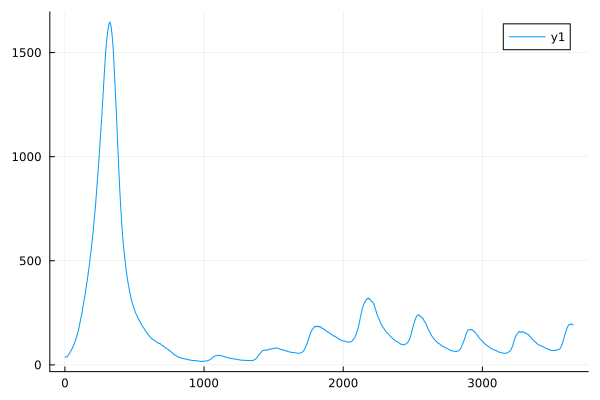

In [1969]:
plot(dd/s)

In [1986]:
ep/s



1.8520772785983337

In [1987]:
mt/s

195.61904761904762

In [1988]:
pd/s

70.64298564165597

In [1989]:
ep/s

1.8520772785983337

In [1475]:
plot()
s = 0
ep = 0
mt = 0
pd = 0
detection_p = 0.05
pop_K = 4200

starting_p = detection_p*pop_K
for i in 1:n_runs
    d, da,f,p = run_analysis(output[i])
    plot!(d, label = "")
    plot!(p, label = "")
    if d[end] > 0

        ep += 100*mean(da[3*365:end])/mean(p[3*365:end])
        pd += 100*(1-mean(p[3*365:end])/pop_K)

        max_d = findmax(d)[2][1]

        if maximum(d) <= starting_p
            take_off_time = 0
        else
            take_off_time = findfirst(>(starting_p), d)[1]
        end

        mt += max_d-take_off_time
        s += 1

    end

end

plot!(title = "$(s)")

LoadError: type Array has no field u

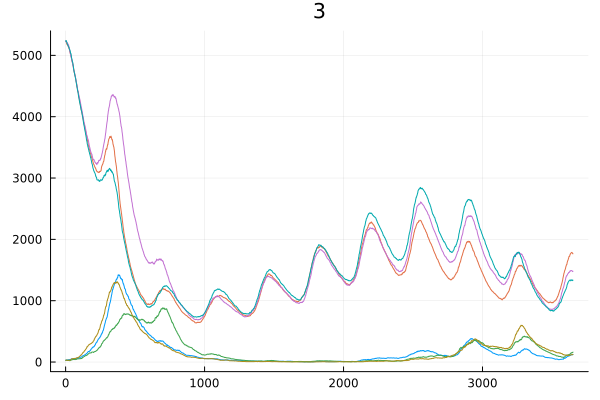

In [249]:
plot()
s = 0
ep = 0
mt = 0
pd = 0
detection_p = 0.05
pop_K = 4200

starting_p = detection_p*pop_K
for i in 1:n_runs
    d, da,f,p = run_analysis(output[i])
    plot!(d, label = "")
    plot!(p, label = "")
    if d[end] > 0

        ep += 100*mean(da[3*365:end])/mean(p[3*365:end])
        pd += 100*(1-mean(p[3*365:end])/pop_K)

        max_d = findmax(d)[2][1]

        if maximum(d) <= starting_p
            take_off_time = 0
        else
            take_off_time = findfirst(>(starting_p), d)[1]
        end

        mt += max_d-take_off_time
        s += 1

    end

end

plot!(title = "$(s)")

In [ ]:
plot()
s = 0
ep = 0
mt = 0
pd = 0
detection_p = 0.05
pop_K = 4200

starting_p = detection_p*pop_K
for i in 1:n_runs
    d, da,f,p = run_analysis(output[i])
    plot!(d, label = "")
    plot!(p, label = "")
    if d[end] > 0

        ep += 100*mean(da[3*365:end])/mean(p[3*365:end])
        pd += 100*(1-mean(p[3*365:end])/pop_K)

        max_d = findmax(d)[2][1]

        if maximum(d) <= starting_p
            take_off_time = 0
        else
            take_off_time = findfirst(>(starting_p), d)[1]
        end

        mt += max_d-take_off_time
        s += 1

    end

end

plot!(title = "$(s)")

In [ ]:
dd[dd.<7] .=0

In [ ]:
t = 1:365
s = 3.165
plot(t,birth_pulse(t,1,s,77.5))
vline!([150])
vline!([60])


In [252]:
n_networks = 3
n_runs = 3
n_years = 6


6

In [1914]:
#Important means

m_t = Normal(180,36.48)
p_d = Normal(75,6.08)
e_p = Normal(1.5,0.304)

Normal{Float64}(μ=1.5, σ=0.304)

In [1947]:
quantile(m_t, [0.25,0.75])

2-element Vector{Float64}:
 155.39461391284695
 204.60538608715305

In [1932]:
sqrt(3*(1-pdf.(m_t, 142.19090995126658)/pdf.(m_t,180))^2)

0.7197669138598748

In [1933]:
a = [1,2,2,2]

4-element Vector{Int64}:
 1
 2
 2
 2

In [1856]:
if length(a) <= 4
    println(3)
end

3


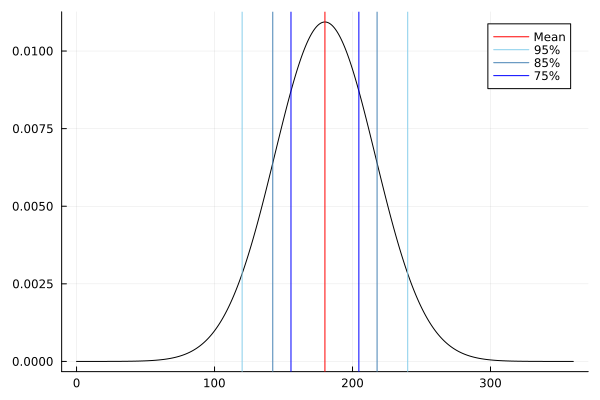

In [1949]:
vᵪ = 0:.1:360
F_s = pdf.(m_t, vᵪ)  # chi distribution with area 1
plot(vᵪ, F_s, label="", color = "black")
vline!([180], c= "red", label = "Mean")

vline!([120], c= "skyblue", label = "95%")
vline!([240], c= "skyblue", label = "")

vline!([142.2], c= "steelblue", label = "85%")
vline!([217.8], c= "steelblue", label = "")

vline!([155.4], c= "blue", label = "75%")
vline!([204.6], c= "blue", label = "")

In [1859]:
function AUSF_d(dis_params,Tspan,U0)
    rj = RegularJump(asf_model_one, regular_c, eqs*nt)
    prob = DiscreteProblem(U0,Tspan,dis_params)
    jump_prob = JumpProblem(prob,Direct(),rj)
    ensemble_prob = EnsembleProblem(jump_prob)
    model_outs = solve(ensemble_prob, SimpleTauLeaping(), trajectories= 3,EnsembleThreads(),dt=1)
    
    res = eval_out(model_outs)
    
end
    
function simulator_function_d(var_params)
    start_day = 180
    
    Tspan = (start_day,365*n_years+start_day)
    
    input = ASF_Inputs.Model_Data(input_path,var_params[4]);
    
    params = ASF_Model.convert(input.Parameters)
    
    U0 = input.U0

    Burn_U0 =  copy(U0)
    Burn_U0[2:5:end] .= 0
    Burn_U0[3:5:end] .= 0
    rj_burn = RegularJump(asf_model_pop, regular_c, eqs*nt)
    prob_burn = DiscreteProblem(Burn_U0,(0.0,275),params)
    jump_prob_burn = JumpProblem(prob_burn, Direct(), rj_burn)
    sol_burn = solve(jump_prob_burn, SimpleTauLeaping(),dt=1);
    
    U_burn = copy(sol_burn[params[18]+start_day]); #population at start date
    rr = rand(1:nt) #seeding diease in starting pop
    ra = rr -1
    if U_burn[ra*5+1] > 1
        U_burn[ra*5+1] = 0
        U_burn[ra*5+2] = 3
        U_burn[ra*5+3] = 2
    else
        U_burn[ra*5+1] = 0
        U_burn[ra*5+3] = 1
    end

    netw = params[3][:,rr] #related populations
    cons = findall(>(0), netw)
    
    if length(cons) <= 4
        wanted = cons
    else
        wanted=shuffle(cons)[1:4] #seeding in 4 other pops so 5 in total!
    end 
    
    for i in cons
        i1 = i -1
        if U_burn[i1*5+1] > 1
            U_burn[i1*5+1] = 0
            U_burn[i1*5+2] = 3
            U_burn[i1*5+3] = 2
        else
            U_burn[i1*5+1] = 0
            U_burn[i1*5+3] = 1
        end

    end
    #beta
    
    params[1] .= var_params[1] #intra
    params[2][params[2] .!= 0 ] .= var_params[2]/n_con #inter
    
    #corpse 
    params[8] = var_params[3] #corpse infection modifier
    AUSF_d(params, Tspan, U_burn)
    
    
end


function eval_out(data) 

    output_final = Matrix{Float64}(undef,(3,1))
    s = 0
    ep = 0
    mt = 0
    pd = 0
    detection_p = 0.05
    pop_K = 5000
    
    starting_p = detection_p*pop_K
    for i in 1:3
        d, da,f,p = run_analysis(data[i])

        if d[end] > 0
            
            ep += 100*mean(da[3*365:end])/mean(p[3*365:end])
            pd += 100*(1-mean(p[3*365:end])/pop_K)
            
            max_d = findmax(d)[2][1]
            
            if maximum(d) <= starting_p
                take_off_time = 0
            else
                take_off_time = findfirst(>(starting_p), d)[1]
            end
            
            mt += max_d-take_off_time
            s += 1

        end

    end
    
    if s >= 2
        output_final[1] = pdf.(e_p,ep/s)/pdf.(e_p,mean(e_p))
        output_final[2] = pdf.(p_d,pd/s)/pdf.(p_d,mean(p_d))
        output_final[3] = pdf.(m_t,mt/s)/pdf.(m_t,mean(m_t))

        
    else
        output_final[1] = 0
        output_final[2] = 0
        output_final[3] = 0
       
    end
   
    return output_final
    
end

function observed_params()
   
    obs =  Matrix{Float64}(undef,(3,1))
    
    obs[1] = 1 #2.5 #endemic prev
    obs[2] = 1#80 #population delcine %
    obs[3] = 1#8 month #time (days) from init to max
    
    return obs
end

observed_params (generic function with 1 method)

In [1950]:
schedule_sig = [1,3/4,1/2];
thresh_shed = zeros(length(schedule_sig))
for (i,v) in enumerate(schedule_sig)
    thresh_shed[i] =  sqrt(3*(pdf.(e_p,(1.5)-0.75*v)/pdf.(e_p,2.5)-1)^2)
end

In [1951]:
thresh_shed = [1.2841903149896468,0.7197669138598748, 0.35225226223770106]

3-element Vector{Float64}:
 1.2841903149896468
 0.7197669138598748
 0.35225226223770106

In [1952]:
input_path = "/home/callum/ASF/Inputs/"; #path to model data
n_years = 10 #how many years each sim will run for
n_runs = 3 #how many runs for each param
n_con = 6  # average number of connections each group has
obs = observed_params() #our observed (just array of ones, we normalise output to be relative to this)
priors = [Uniform(0.1, 1.0), Uniform(0.01, 0.1), Uniform(0, 1.0), Uniform(0,0.5)];

In [1953]:
n_particles = 100;

In [1954]:
sim_abcsmc_res = SimulatedABCSMC(obs,simulator_function_d,priors,thresh_shed,n_particles; write_progress=true)

┌ Info: GpABC rejection simulation. ϵ = 1.2841903149896468.
└ @ GpABC /home/callum/.julia/packages/GpABC/o0EN1/src/abc/rejection.jl:47
┌ Info: GpABC SMC simulation ϵ = 0.7197669138598748
└ @ GpABC /home/callum/.julia/packages/GpABC/o0EN1/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.35225226223770106
└ @ GpABC /home/callum/.julia/packages/GpABC/o0EN1/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation accepted 16/1000 particles.
└ @ GpABC /home/callum/.julia/packages/GpABC/o0EN1/src/abc/smc.jl:238
┌ Warning: Simulation reached maximum 1000 iterations before finding 100 particles - will return 16
└ @ GpABC /home/callum/.julia/packages/GpABC/o0EN1/src/abc/smc.jl:248


GpABC.SimulatedABCSMCOutput(4, [100, 100, 16], [296, 607, 1000], [1.2841903149896468, 0.7197669138598748, 0.35225226223770106], AbstractMatrix{Float64}[[0.17109964359588375 0.06633197558483907 0.9022385053860205 0.08364779398056998; 0.4726355982227347 0.03228940541645847 0.7651454553961737 0.28576793122122185; … ; 0.5669598987231866 0.09226194029043082 0.4795934003357065 0.049420722312543686; 0.14402075960244848 0.06892321721616819 0.600531340965014 0.19543622426041163], [0.5448611472417665 0.057033636086897266 0.3926508180520969 0.28367242843597523; 0.3943885747655101 0.05597015814203564 0.6420165639447903 0.07769340153126708; … ; 0.5627871196333664 0.041652340984489306 0.5884039522955256 0.17812956438710825; 0.604686886187876 0.06724942671464659 0.21759022762550417 0.4016399667287574], [0.559315668814533 0.07681996040196883 0.4329460097745427 0.15704597980780355; 0.5609101294897745 0.07192035803310884 0.3658251624932684 0.13804173063101477; … ; 0.4495954059730337 0.035226403584630264

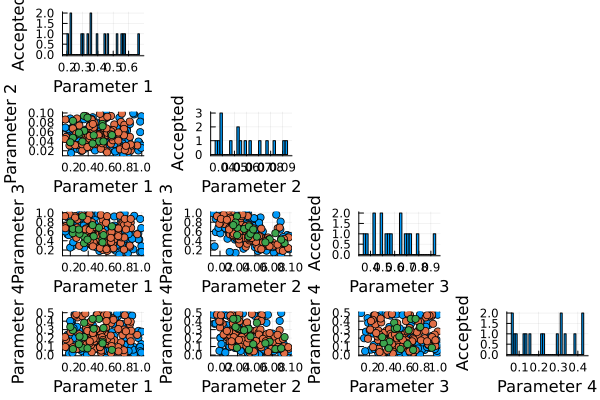

In [1955]:
plot(sim_abcsmc_res)

In [1866]:
    sim_abcsmc_res.population[3][1,:]

LoadError: BoundsError: attempt to access 2-element Vector{AbstractMatrix{Float64}} at index [3]

In [1957]:
data = sim_abcsmc_res.population[1]
vars = ["β_intra", "β_inter", "ω", "p"]
for i in 1:4
    wanted = data[:,i]
    println(vars[i])
    println("Median: ", round(median(wanted),digits=4))
    println("Mean: ", round(mean(wanted), digits=4))
    
    println()
end

β_intra
Median: 0.6006
Mean: 0.5742

β_inter
Median: 0.0514
Mean: 0.0527

ω
Median: 0.5465
Mean: 0.5641

p
Median: 0.1575
Mean: 0.1991



In [1119]:
    data = sim_abcsmc_res.population[2]
vars = ["β_intra", "β_inter", "ω", "p"]
for i in 1:4
    wanted = data[:,i]
    println(vars[i])
    println("Median: ", round(median(wanted),digits=4))
    println("Mean: ", round(mean(wanted), digits=4))
    
    println()
end

β_intra
Median: 0.6073
Mean: 0.6083

β_inter
Median: 0.0568
Mean: 0.0574

ω
Median: 0.7758
Mean: 0.7682

p
Median: 0.0162
Mean: 0.017



In [1959]:
    data = sim_abcsmc_res.population[3]
vars = ["β_intra", "β_inter", "ω", "p"]
for i in 1:4
    wanted = data[:,i]
    println(vars[i])
    println("Median: ", round(median(wanted),digits=4))
    println("Mean: ", round(mean(wanted), digits=4))
    
    println()
end

β_intra
Median: 0.3739
Mean: 0.405

β_inter
Median: 0.054
Mean: 0.0585

ω
Median: 0.5558
Mean: 0.5834

p
Median: 0.2158
Mean: 0.2275



In [2005]:
    data = sim_abcsmc_res.population[2]
vars = ["β_intra", "β_inter", "ω", "p"]
for i in 1:4
    wanted = data[:,i]
    println(vars[i])
    println("Median: ", round(median(wanted),digits=4))
    println("Mean: ", round(mean(wanted), digits=4))
    
    println()
end

β_intra
Median: 0.5232
Mean: 0.5299

β_inter
Median: 0.0514
Mean: 0.0523

ω
Median: 0.5411
Mean: 0.571

p
Median: 0.2117
Mean: 0.2317



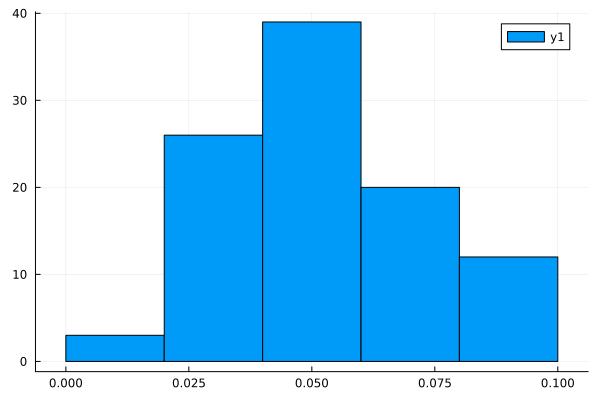

In [2008]:
histogram(data[:,2], bin)